In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt, binary_dilation
from dnet import dnet2d

%matplotlib inline

In [2]:
import tensorflow as tf

In [20]:
params = dict()

params['width'] = 512
params['height'] = 512
params['nchannels'] = 1
params['channels'] = [0]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['net_sizes'] = [[16, 1, 1], [16, 3, 1], [16, 3, 2],
                       [16, 3, 3], [16, 3, 4], [16, 3, 5], [2, 1, 1]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [21]:
all_data_tif = imread('/scratch/cjw/Data/EM/Training.tif_RotShift.tif')
all_data_tif.shape

(400, 2, 512, 512)

In [22]:
    
## read in the data

data_tif = all_data_tif[:,0, :, :]
labels_tif = all_data_tif[:,1, :, :]
labels_tif = binary_dilation(labels_tif).astype(labels_tif.dtype)
#labels_tif = binary_dilation(labels_tif).astype(labels_tif.dtype)
print(labels_tif.shape)

#create the background channel for the labels
labshape = labels_tif.shape

temp = 0*labels_tif
labels_tif = np.stack([labels_tif, temp], axis=-1)
print(labels_tif.shape)

#normalize images 0-1
#try normalizing wit zero mean and equal sdev

dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
dmean = data_tif.mean(axis=(1,2),keepdims=True)
dstd = data_tif.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
data = (data_tif - dmean)/dstd
data = np.expand_dims(data, -1)
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())
labels[:,:,:,-1] = (labels[:,:,:, 0] < .5).astype(np.float32)
#put cells with both channels into channel 0
# lsum = labels.sum(axis=(-1))
# s2 = lsum > 1
# s2 = s2.astype(np.float32)
# labels[:,:,:,1] -= s2 
data_tif.shape, data.shape, labels.shape, labels_tif.shape, labels.max(axis=(0,1,2))

(400, 512, 512)
(400, 512, 512, 2)


((400, 512, 512),
 (400, 512, 512, 1),
 (400, 512, 512, 2),
 (400, 512, 512, 2),
 array([1., 1.]))

dtype('bool')

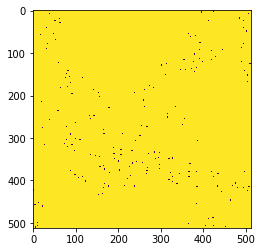

In [23]:
plt.imshow(labels[0,:,:,1])
(labels[:,:,:,1] > .5).dtype

In [24]:

tf.reset_default_graph()
u = dnet2d.dnet2d(params)
u.x = data
u.y = labels

In [25]:
w = 512

In [26]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, w, w, labels.shape[-1]))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [27]:
enc = u.create_dnet(images, True)

[16, 1, 1] <class 'int'>
Tensor("net-layer-0-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("net-layer-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("Placeholder:0", shape=(?, 512, 512, 1), dtype=float32)
----
[16, 3, 1] <class 'int'>
Tensor("net-layer-1-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("net-layer-1/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("net-layer-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
----
[16, 3, 2] <class 'int'>
Tensor("net-layer-2-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("net-layer-2/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("add:0", shape=(?, 512, 512, 16), dtype=float32)
----
[16, 3, 3] <class 'int'>
Tensor("net-layer-3-0/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("net-layer-3/BiasAdd:0", shape=(?, 512, 512, 16), dtype=float32)
Tensor("add_1:0", shape=(?, 512, 512, 16), dtype=float32)
----
[16, 3, 4] <class 'int'>
Tensor("net-layer-4-0/

In [28]:
u.net

<tf.Tensor 'encoder-2:0' shape=(?, 512, 512, 2) dtype=float32>

In [29]:
#d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

In [30]:
u.x.shape, u.y.shape

((400, 512, 512, 1), (400, 512, 512, 2))

In [31]:
#u.set_validation(20)
u.xtrain = u.x[0:375,:,:]
u.ytrain = u.y[0:375,:,:]
u.xtest = u.x[375:,:,:]
u.ytest = u.y[375:,:,:]

In [32]:
sess = tf.Session()

In [33]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [34]:
sess.run(tf.global_variables_initializer())

In [35]:
u.stdev = 0.1
#u.learning_rate = 0.0001

0 0.58480334 0.58480334 0.2528661 0.747134 0.009999999
11


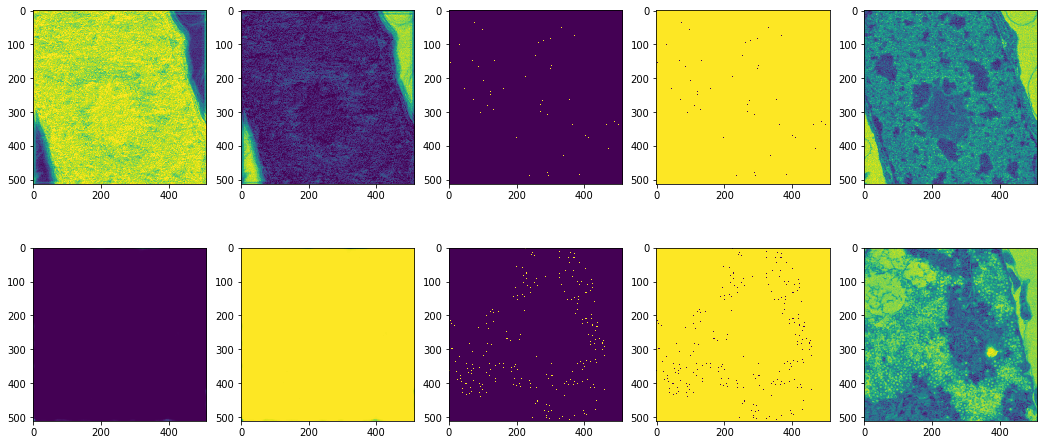

0 0.58480334 2.2223289012908936 0.009999999
10 0.022309842 2.046131134033203 0.009999989000005507
20 0.019156761 2.5933923721313477 0.009999979000021012
30 0.019621843 2.661820888519287 0.009999969000046518
40 0.020355199 2.734684705734253 0.009999959000082024
50 0.020495202 2.587421417236328 0.009999949000127527
60 0.020007363 1.6978635787963867 0.009999939000183033
70 0.017736975 2.7117018699645996 0.009999929000248538
80 0.017214058 2.4640913009643555 0.009999919000324044
90 0.01122308 2.1373279094696045 0.009999909000409549
100 0.013806074 0.013806074 1.9253184e-05 0.9999807 0.009999899000505054
8


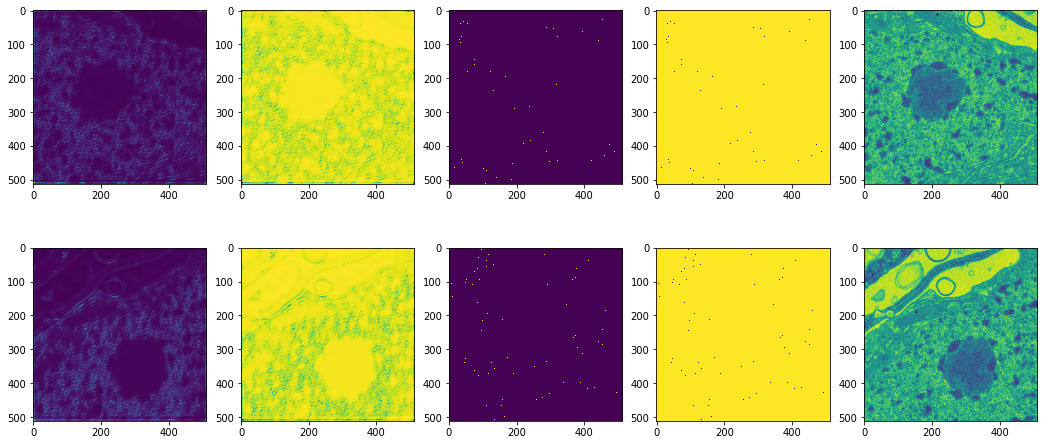

100 0.013806074 4.068156957626343 0.009999899000505054
110 0.017875168 1.8646748065948486 0.009999889000610558
120 0.015060369 2.070967435836792 0.009999879000726063
130 0.01595026 2.716355085372925 0.009999869000851567
140 0.01219854 2.1112942695617676 0.009999859000987071
150 0.0135181965 2.602114677429199 0.009999849001132577
160 0.015969584 2.6048784255981445 0.009999839001288079
170 0.012602231 2.712920665740967 0.009999829001453584
180 0.012671754 2.7333321571350098 0.009999819001629088
190 0.012335202 2.6540091037750244 0.00999980900181459
200 0.015533184 0.015533184 1.3625875e-07 0.9999999 0.009999799002010094
12


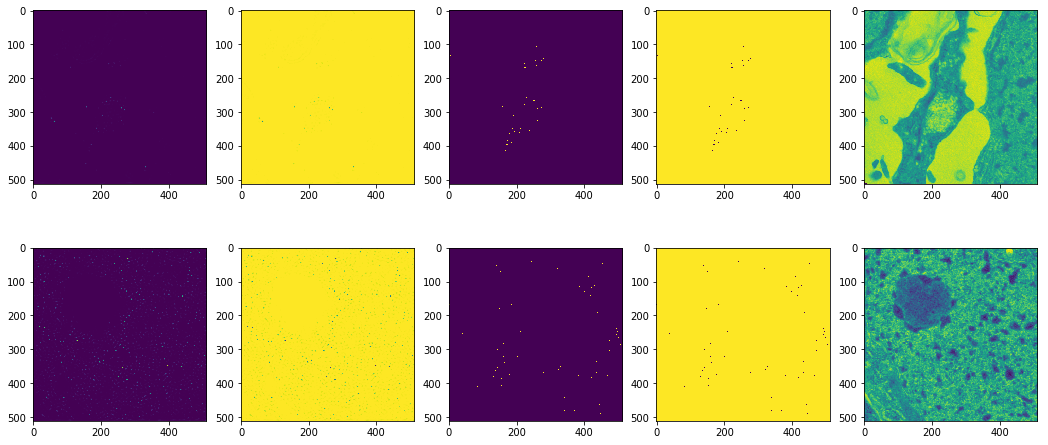

200 0.015533184 2.996180772781372 0.009999799002010094
210 0.01435882 2.623192310333252 0.009999789002215598
220 0.015846085 1.799452543258667 0.009999779002431099
230 0.014160039 1.9583616256713867 0.009999769002656603
240 0.014559207 2.1600899696350098 0.009999759002892105
250 0.014306322 2.695939779281616 0.009999749003137607
260 0.014266078 2.9851338863372803 0.00999973900339311
270 0.014588298 2.654947280883789 0.00999972900365861
280 0.013355509 2.0819897651672363 0.009999719003934112
290 0.013210408 2.703415870666504 0.009999709004219613
300 0.012669455 0.012669455 1.1384914e-06 0.9999988 0.009999699004515115
2


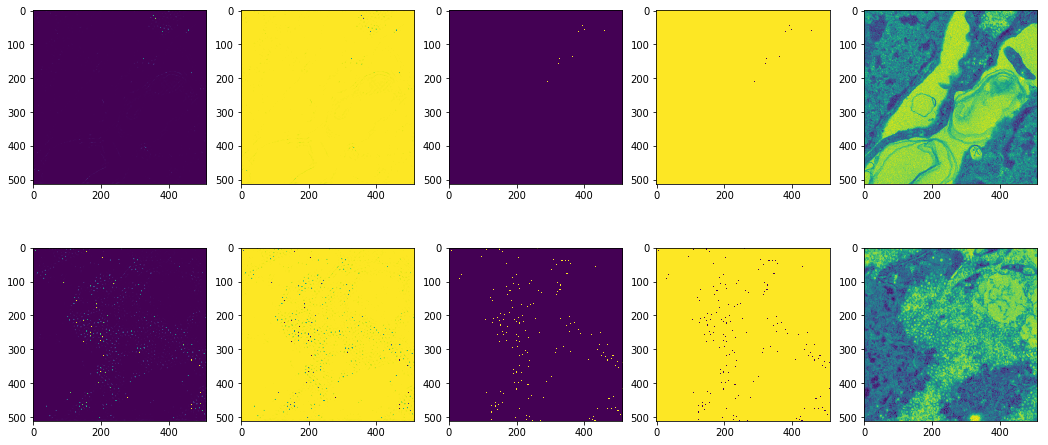

300 0.012669455 3.7817225456237793 0.009999699004515115
310 0.0128934635 2.7349555492401123 0.009999689004820613
320 0.013621458 2.6326045989990234 0.009999679005136115
330 0.0123481285 1.8390281200408936 0.009999669005461615
340 0.011560602 2.738203763961792 0.009999659005797114
350 0.015111478 2.0368247032165527 0.009999649006142614
360 0.013879841 2.6961076259613037 0.009999639006498112
370 0.0125471 2.0386438369750977 0.009999629006863612
380 0.011868057 1.982546091079712 0.00999961900723911
390 0.0131858615 2.0548338890075684 0.009999609007624609
400 0.013187373 0.013187373 1.8581582e-06 0.9999981 0.009999599008020105
6


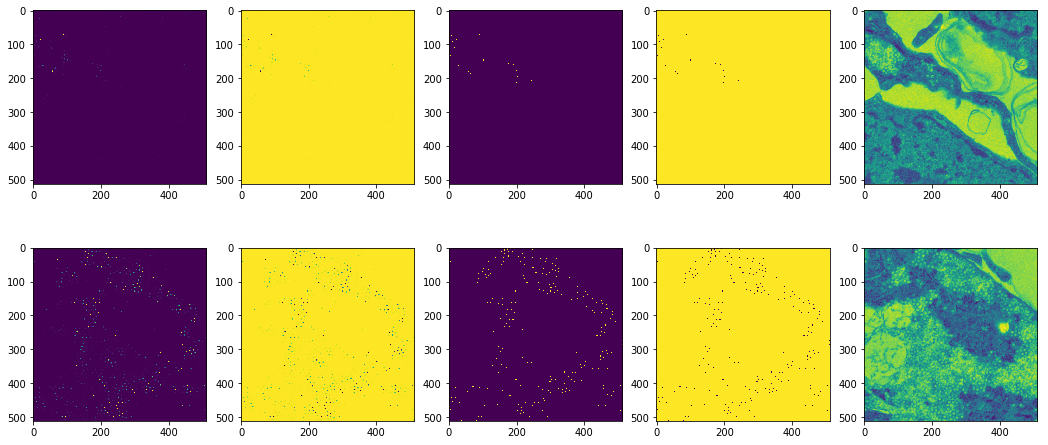

400 0.013187373 4.000912666320801 0.009999599008020105
410 0.013022407 2.7019097805023193 0.009999589008425602
420 0.012309117 2.2883901596069336 0.0099995790088411
430 0.0130512845 2.560335874557495 0.009999569009266594
440 0.011892755 2.657130241394043 0.00999955900970209
450 0.009625772 2.5949161052703857 0.009999549010147586
460 0.012228114 1.5189976692199707 0.009999539010603081
470 0.013134366 2.6068315505981445 0.009999529011068575
480 0.013030505 2.184607744216919 0.00999951901154407
490 0.013708678 2.544926166534424 0.009999509012029563
500 0.012258916 0.012258916 3.3041803e-07 0.99999964 0.009999499012525056
11


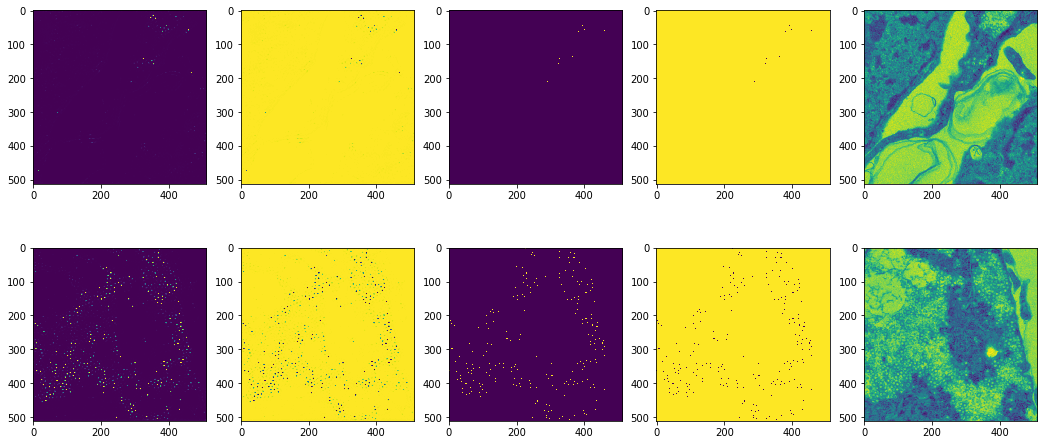

500 0.012258916 4.081881761550903 0.009999499012525056
510 0.012976315 1.977912425994873 0.00999948901303055
520 0.011657988 2.73362398147583 0.009999479013546041
530 0.012241436 2.7682714462280273 0.009999469014071533
540 0.012270094 1.8645296096801758 0.009999459014607023
550 0.011831347 2.0848209857940674 0.009999449015152513
560 0.013490176 2.1026904582977295 0.009999439015708003
570 0.011212694 2.5644338130950928 0.009999429016273492
580 0.011831873 2.6962428092956543 0.009999419016848981
590 0.011938663 2.0767662525177 0.00999940901743447
600 0.011057944 0.011057944 1.1710629e-06 0.9999988 0.009999399018029957
6


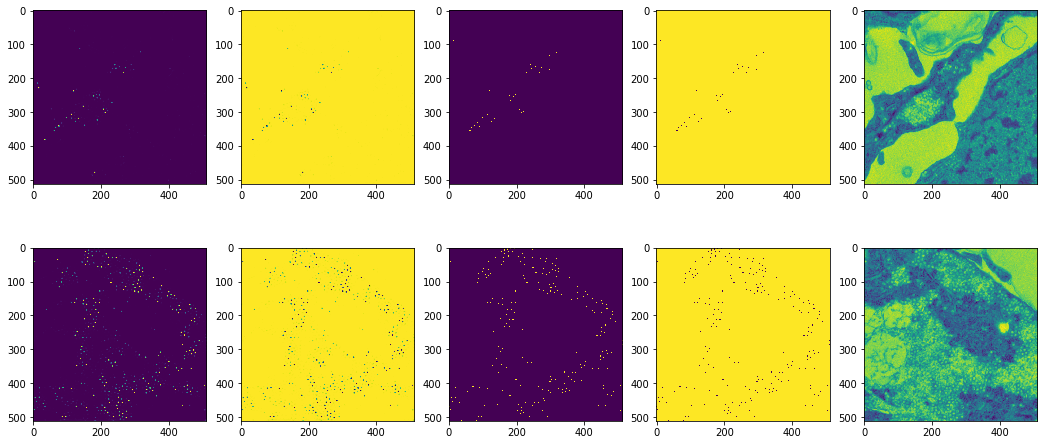

600 0.011057944 3.980982780456543 0.009999399018029957
610 0.011802102 1.6957612037658691 0.009999389018635443
620 0.013143896 1.9867041110992432 0.00999937901925093
630 0.011121204 2.1473522186279297 0.009999369019876416
640 0.011823342 2.565995931625366 0.0099993590205119
650 0.009892136 2.660309314727783 0.009999349021157386
660 0.012042243 2.5784804821014404 0.00999933902181287
670 0.010225206 2.710843324661255 0.009999329022478354
680 0.011210985 2.069235324859619 0.009999319023153836
690 0.012834265 2.7551331520080566 0.009999309023839317
700 0.011245384 0.011245384 9.718277e-06 0.9999902 0.0099992990245348
11


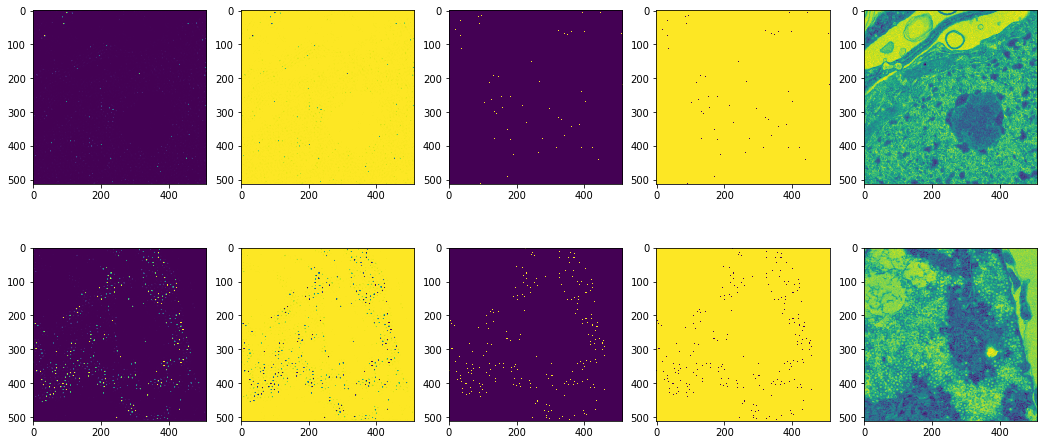

700 0.011245384 4.0195112228393555 0.0099992990245348
710 0.011507432 1.9677197933197021 0.009999289025240278
720 0.010873772 1.9696133136749268 0.009999279025955758
730 0.011852943 1.9520363807678223 0.009999269026681237
740 0.010324871 2.6017353534698486 0.009999259027416716
750 0.009219077 1.9949414730072021 0.009999249028162193
760 0.011819369 2.655871629714966 0.00999923902891767
770 0.009729925 2.6699512004852295 0.009999229029683147
780 0.010720753 2.7141776084899902 0.009999219030458622
790 0.01048354 1.9692256450653076 0.009999209031244096
800 0.012911025 0.012911025 7.623999e-07 0.9999993 0.00999919903203957
3


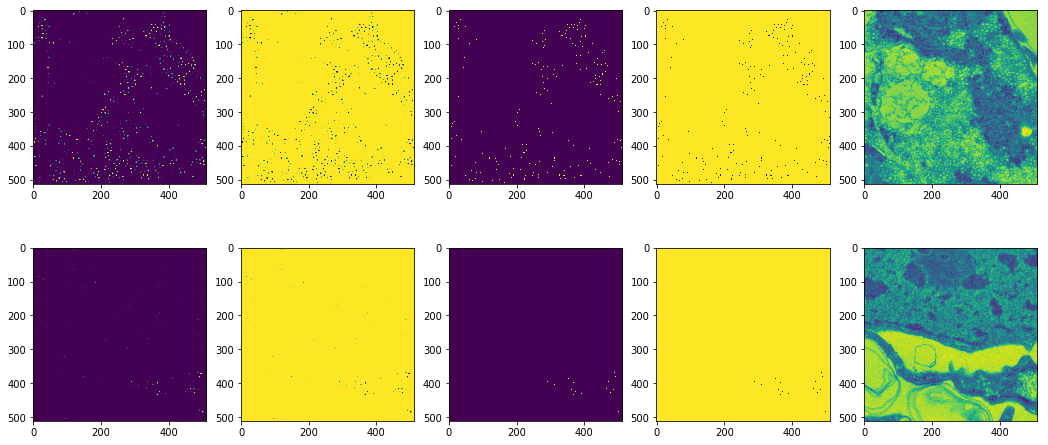

800 0.012911025 3.9633731842041016 0.00999919903203957
810 0.01176429 2.727494955062866 0.009999189032845043
820 0.012049047 1.7587718963623047 0.009999179033660516


KeyboardInterrupt: 

In [36]:

rate = 0.01
#loss_file = open('progress.dat', 'w', buffering=1)

tbx, tbm = u.get_simple_batch(16)
for i in range(2500):
    t1 = time.time()
    rate = np.maximum(rate*.9999999, 0.000005)
    bx, bm = u.get_simple_batch(32)
#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,16)
        #nr = np.argmin(res[:,:,:,4].sum(axis=(1,2)))
        print(nr)
        
        tres = sess.run(u.decoder_softmax,
                           feed_dict={images:tbx, learning_rate:rate})
        
        plt.figure(figsize=(18,8))
        plt.subplot(2,5,1)
        plt.imshow(res[nr,:,:,0])
        plt.subplot(2,5,2)
        plt.imshow(res[nr,:,:,1])
        plt.subplot(2,5,3)
        plt.imshow(bm[nr,:,:,0])
        plt.subplot(2,5,4)
        plt.imshow(bm[nr,:,:,1])
        plt.subplot(2,5,5)
        bxd = bx[nr,:,:,0]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
        plt.subplot(2,5,6)
        plt.imshow(tres[nr,:,:,0])
        plt.subplot(2,5,7)
        plt.imshow(tres[nr,:,:,1])
        plt.subplot(2,5,8)
        plt.imshow(tbm[nr,:,:,0])
        plt.subplot(2,5,9)
        plt.imshow(tbm[nr,:,:,1])
        plt.subplot(2,5,10)
        bxd = tbx[nr,:,:,0]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
    
#         plt.imshow(res[nr,:,:,5])
#         plt.subplot(2,5,7)
#         plt.imshow(res[nr,:,:,6])
#         plt.subplot(2,5,8)
#         plt.imshow(res[nr,:,:,7])
#         plt.subplot(2,5,9)
#         plt.imshow(res[nr,:,:,8])
#         plt.subplot(1,6,4)
#         plt.imshow(res[nr,:,:,1])
#         plt.subplot(1,6,5)
#         plt.imshow(bm[nr,:,:,1])
#         plt.subplot(1,6,6)
#         plt.imshow(bx[nr,:,:,1])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


(32, 512, 512, 2)


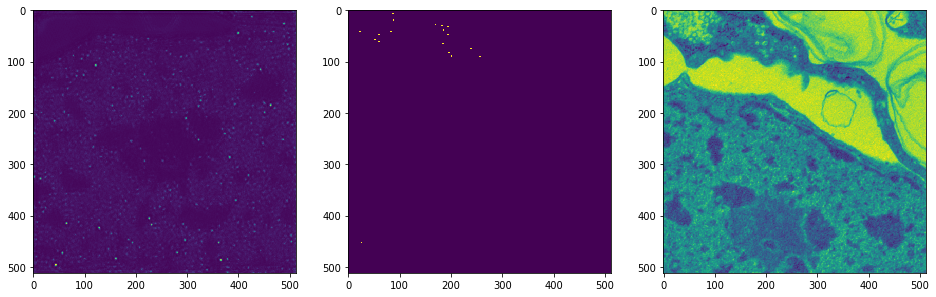

In [42]:
na = 1
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(np.sqrt(res[na,:,:,0]))
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,0])


In [23]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

ValueError: cannot reshape array of size 327680 into shape (3)

In [63]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/16_hours_punched_overnight/NDExp_Point0008_Seq0008.tif')
test_tif = u.xtest
#test_tif = labels[-1,:,:,:] #imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0021_Seq0021.tif')
# ymax = test_tif.max(axis=(0,1), keepdims=True)
# ymin = test_tif.min(axis=(0,1), keepdims=True)
# ymean = test_tif.mean(axis=(0,1), keepdims=True)
# ystd = test_tif.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
test_tif = (test_tif - ymean)/ystd
test_tif.shape, ymin.shape

vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:u.xtest})

vres0.shape

(25, 512, 512, 2)

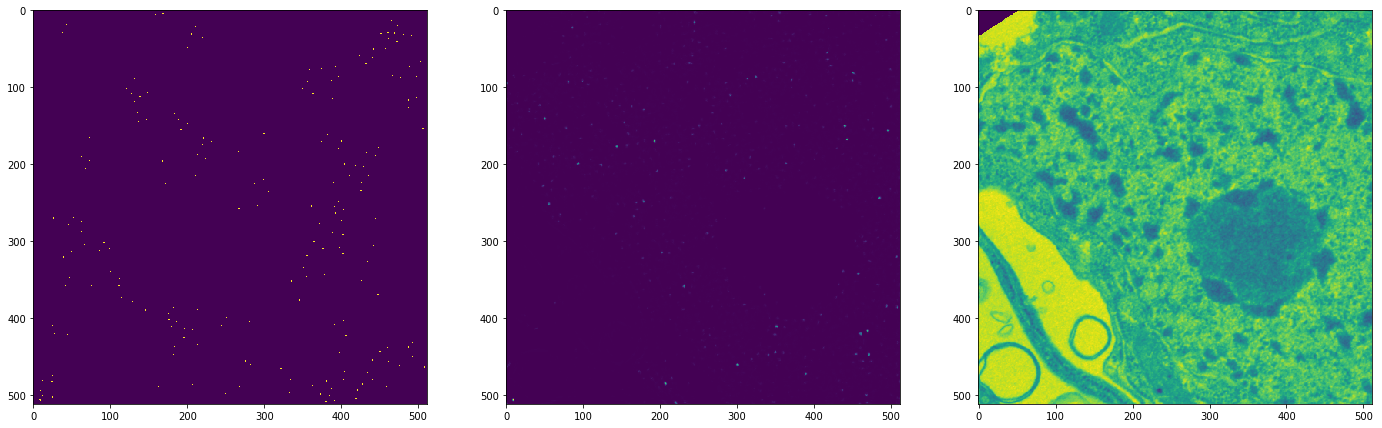

In [88]:
na = 10
plt.figure(figsize=(24,12))
plt.subplot(1,3,1)
plt.imshow(u.ytest[na, :,:,0])
plt.subplot(1,3,2)
plt.imshow(vres0[na,:,:,0])
plt.subplot(1,3,3)
plt.imshow(u.xtest[na,:,:,0])

In [39]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

0
128


((36, 256, 256, 3), (36, 256, 256, 3))

In [40]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

((36, 256, 256, 5), (36, 256, 256, 5))

In [41]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 5), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

((1664, 1664, 5), 1.0)

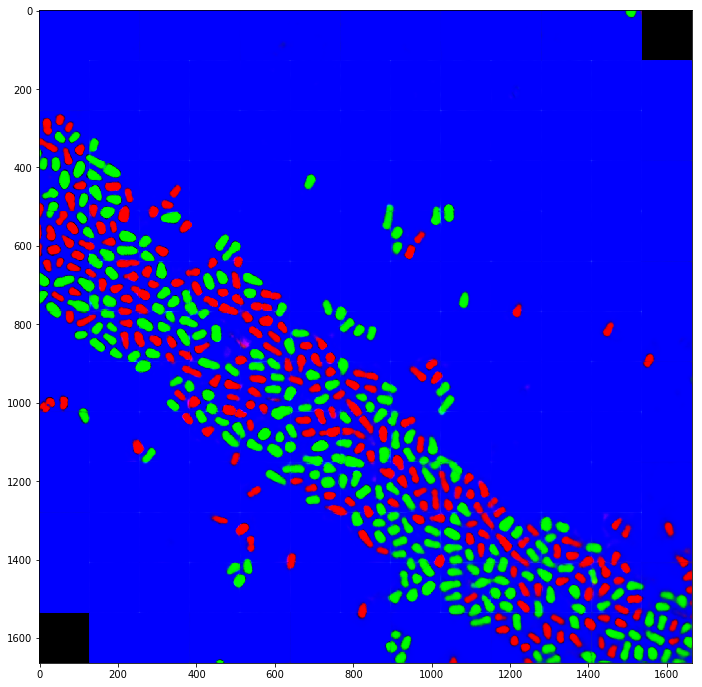

In [42]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,0:3]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [ ]:
plt.imshow(tc0[0,:,:,0])

In [ ]:
import tifffile
r.shape

In [ ]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017-2.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

In [ ]:
plt.imshow(data[6,:,:,0:3])

In [ ]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

In [30]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint', global_step=5000)

'/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint-5000'